In [1]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import pathlib
import pandas as pd
import math

import io
import requests
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam

In [2]:
# Download the csv from github of anais
art = pd.read_csv('artworks_with_prices_findartinfo.csv')

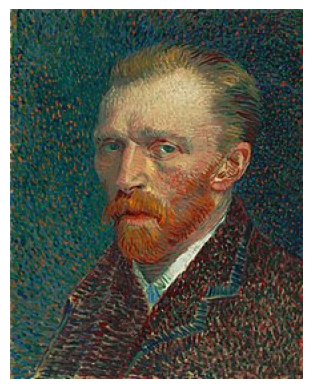

In [3]:
def display_artwork(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
display_artwork(pictures.url.values[0])

In [4]:
# Collect all data

# Convolutional neural network (CNN) needs same shapes as input, so add zero padding untill max size of all images
new_width = 660
new_height = 660

# Resize images to make it computationally less heavy, might be removed in final regressor
img_size = 224

# Number of images loaded to train regressor, note some images will be removed because they do not have ratings
tot_im = 1000


def get_train_data(label, start_id, end_id):
    x_data = [] 
    y_data = []
    url = label.image_url
    for i in range(start_id,end_id):#label.id:
        try:
            response = requests.get(url[i])
            image = Image.open(io.BytesIO(response.content))
            # Padding
            #result = Image.new(image.mode, (new_width, new_height))
            #result.paste(image, (0,0))
            #result = result.resize((img_size, img_size))
            
            # Cropping
            size = min(image.size)  -40     # New dimension
            width, height = image.size   # Get dimensions

            left = (width   - size)/2
            top = (height   - size)/2
            right = (width  + size)/2
            bottom = (height+ size)/2

            # Crop the center of the image
            result = image.crop((left, top, right, bottom))
            result = result.resize((img_size, img_size))
            
            if ((np.asarray(result).shape == (img_size,img_size,3))
                and (not math.isnan(label.price[i]))):
                x_data.append(np.asarray(result))
                y_data.append(label.price[i])
        except Exception as e:
            print(e)
    return (x_data, y_data)

(x_train,y_train) =get_train_data(art, 0, tot_im)
tot_val_im = int(0.2*tot_im)
(x_val, y_val) = get_train_data(art, tot_im, tot_im+tot_val_im)
(x_test, y_test) = get_train_data(art, tot_im+tot_val_im, tot_im+tot_val_im+int(0.1*tot_im))

HTTPSConnectionPool(host='kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com', port=443): Max retries exceeded with url: /images/Albert+Bierstadt/Cathedral+Rocks%2C+Yosemite+Valley%2C+California.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001A71E61E110>, 'Connection to kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com timed out. (connect timeout=None)'))
HTTPSConnectionPool(host='kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com', port=443): Max retries exceeded with url: /images/Bartlett%2C+William+Henry/Londonderry%2C+County+Londonderry%2C+Northern+Ireland.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001A71E5D3640>, 'Connection to kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com timed out. (connect timeout=None)'))


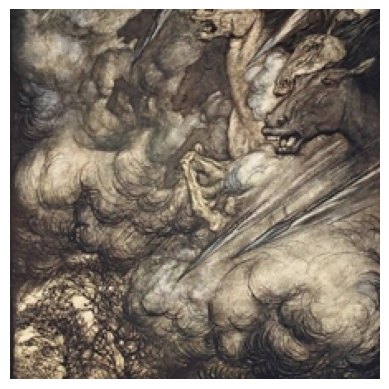

[1.55000e+03 5.29700e+04 5.29700e+04 5.29700e+04 5.29700e+04 2.86800e+04
 5.29700e+04 1.94220e+04 5.29700e+04 2.86800e+04 2.96300e+03 2.86800e+04
 5.29700e+04 2.96300e+03 5.29700e+04 5.07630e+04 2.02000e+02 6.75000e+03
 5.29700e+04 6.90000e+01 5.29700e+04 8.36500e+03 5.29700e+04 2.37500e+04
 1.80000e+05 1.02000e+05 7.80000e+04 3.60000e+06 7.20000e+04 6.50000e+04
 2.28000e+03 7.20000e+04 1.78250e+04 8.40000e+03 3.60000e+06 3.30000e+05
 2.12500e+04 1.42200e+03 8.00000e+05 1.20000e+04 5.50000e+04 8.95000e+04
 4.40900e+06 4.68750e+04 1.42400e+05 3.27600e+05 1.22677e+05 4.75000e+04
 1.22677e+05 4.13000e+02 4.40900e+06 2.00000e+03 8.20000e+02 1.87950e+06
 2.35000e+04 9.85000e+04 1.93790e+04 9.68960e+04 9.68960e+04 1.31560e+04
 1.93790e+04 2.36810e+04 1.93790e+04 1.76900e+03 9.68960e+04]


In [5]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
plt.imshow(x_test[2])
plt.axis("off")
plt.show()
print(y_test)

In [11]:
# Data augmentation: at the moment rescale and shifts
train_datagen = ImageDataGenerator(
        rescale = 1/255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # Randomly zoom image 
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip = False)  # randomly flip images
train_datagen.fit(x_train)

In [15]:
# Load VGG16, add some top layers
from keras.applications import VGG16
model3 = VGG16(weights = 'imagenet', include_top=False, input_shape=(224,224,3)) #weights = 'imagenet', include_top = False
for layer in model3.layers:
    layer.trainable=False
model3 = Sequential(model3)
model3.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(1, activation = 'linear'))
model3.compile(optimizer = 'adam', loss = 'mse', metrics = ['mean_absolute_percentage_error']) # mape = 100 * abs((y_true - y_pred) / y_true)
print(model3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 64)               

In [ ]:
# Train CNN
epochs = 10
batch_size = 32
history = model3.fit(train_datagen.flow(x_train, y_train), batch_size=batch_size,
         validation_data = (x_val, y_val), epochs=epochs, verbose=1)


Epoch 1/10
 2/21 [=>............................] - ETA: 1:55 - loss: 108762236977152.0000 - mean_absolute_percentage_error: 1638.4258

In [ ]:
# Check predictions
part_x = x_train[:10]
y_pred = model3.predict(part_x)
print(y_train[:10],y_test_pred)

part_x = x_val[:10]
y_pred = model3.predict(part_x)
print(y_val[:10],y_test_pred)

part_x = x_test[:10]
y_pred = model3.predict(part_x)
print(y_test[:10],y_test_pred)